In [149]:
import matplotlib
matplotlib.use('nbagg')

import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

In [4]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = data_frame.join(target_frame.set_index('dim_user_gid'), how="inner")
    
    print("\nA short summary:")
    print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        
    print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
    print("It was sorted by the dim_user_gid column.\n")
    
    return result

In [5]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [6]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [8]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

### Loading the Features

In [9]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# # Data with 5 million users
# file_name = "Data/data_features_5_million_users_20220915.pkl"

# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
file_name = "Data/data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"

In [10]:
data_for_clustering = read_data_from_pickle(file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid  est_seniority top_platform  level  trstier level_bracket  \
23899           261           3628        Apple   74.0      2.0      lv_40_79   
40151           288           3628       Google   77.0      1.0      lv_40_79   
40152           312           3628       Google   97.0      1.0     lv_80_119   
40153           376           3628       Google  126.0      3.0    lv_120_139   
68592           381           3628       Google  129.0      2.0    lv_120_139   
80781           388           3628        Apple   85.0      2.0     lv_80_119   
48277           391           3628          Web  243.0      2.0    lv_200plus   
3584            427           3628     Facebook  208.0      3.0    lv_200plus   
48278           436           3628     Facebook   72.0      2.0      lv_40_79   
68593           454           3628       Google   64.0      2.0      lv_40_79   

       is_elite  is_vip  llrecency  Lifetime_Revenue_Net  \
23899         0       0          4                0.0000   
40151         0       0          1                0.0000   
40152         0       0          1                0.0000   
40153         0       0         10               85.1555   
68592         0       0          1              110.9604   
80781         0       0        121                3.8430   
48277         0       0          1                0.0000   
3584          0       0          1                0.0000   
48278         0       0         41                0.0000   
68593         0       0         49                0.0000   

       Last_30D_Revenue_Net  Last_90D_Revenue_Net  Last_30D_Transactions  \
23899                   0.0                 0.000                      0   
40151                   0.0                 0.000                      0   
40152                   0.0                 0.000                      0   
40153                   0.0                10.493                      0   
68592                   0.0                10.493                      0   
80781                   0.0                 0.000                      0   
48277                   0.0                 0.000                      0   
3584                    0.0                 0.000                      0   
48278                   0.0                 0.000                      0   
68593                   0.0                 0.000                      0   

       Last_30D_Gross_Sink  Last_90D_Gross_Sink  Last_30D_Login_days  \
23899                 42.0                 42.0                    2   
40151                  0.0                  0.0                    6   
40152              16952.0              53355.0                   29   
40153                  0.0               2652.0                    1   
68592                450.0              25135.0                   10   
80781                  0.0                  0.0                    0   
48277              11580.0              34815.0                   30   
3584               21180.0             238137.0                   27   
48278                  0.0                772.0                    0   
68593                  0.0               1944.0                    0   

       Last_90D_Login_days  credits_balance_EOD  coins_balance_EOD  \
23899                    2              23992.0           989739.0   
40151                   17                591.0           129887.0   
40152                   89                279.0           485502.0   
40153                    7               2278.0          2863137.0   
68592                   36               5698.0          1277645.0   
80781                    0               1414.0             4238.0   
48277                   90                  4.0             4128.0   
3584                    87                426.0             9904.0   
48278                    1                204.0           342700.0   
68593                    1                207.0            25913.0   

       number_of_bingo_rounds  Life_Time_Login_Days  

### Loading the revenue target and initial data analysis

In [11]:
target_file_name = "Data/data_target_revenue_20220916.pkl"

In [12]:
data_target_revenue = read_data_from_pickle(target_file_name)
data_target_revenue.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid revenue_converted_net
17184           600                2.9153
81484          1240                3.4930
85786          1307                0.6230
34537          1621               10.4930
72900          1788                6.2930
72899          1788                6.2930
72898          1788                6.2930
72897          1788                0.6930
72896          1788               10.4930
21602          2082               19.5930

In [13]:
# Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
data_target_revenue['Total_revenue_at_day'] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

# Adding a column with the number of purchase events of a user
data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

# Keeping just the information per a user id
data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)

data_target_revenue.head(10)

dim_user_gid  Total_revenue_at_day  num_purchase_events_of_user
17184           600                2.9153                            1
81484          1240                3.4930                            1
85786          1307                0.6230                            1
34537          1621               10.4930                            1
72900          1788               30.0650                            5
21602          2082               68.5510                            7
47251          2115               19.5965                            1
89753          2136                0.7184                            1
94256          2295               59.5080                            5
56186          2377                8.7777                            1

In [14]:
print("The shape of the target data frame is:\n{}".format(data_target_revenue.shape))
print("\nAnd the types of the data is:")
print(data_target_revenue.dtypes)

The shape of the target data frame is:
(51856, 3)

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [15]:
column = "Total_revenue_at_day"
print("There are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue['Total_revenue_at_day'] == 0]), data_target_revenue[column].isnull().sum(), column))

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column


The revenue data set only includes paying users.   
So in the clustering, it is expected that this users will be at only a few clusters -> as the vast majority of the users in the general population are non-paying users. 

So I expect a low spread of target among the clusters that will include the non-paying users, and a high spread among the cluster(s) that will include the paying users. Unless the clustering is done on only paying users. 

<IPython.core.display.Javascript object>


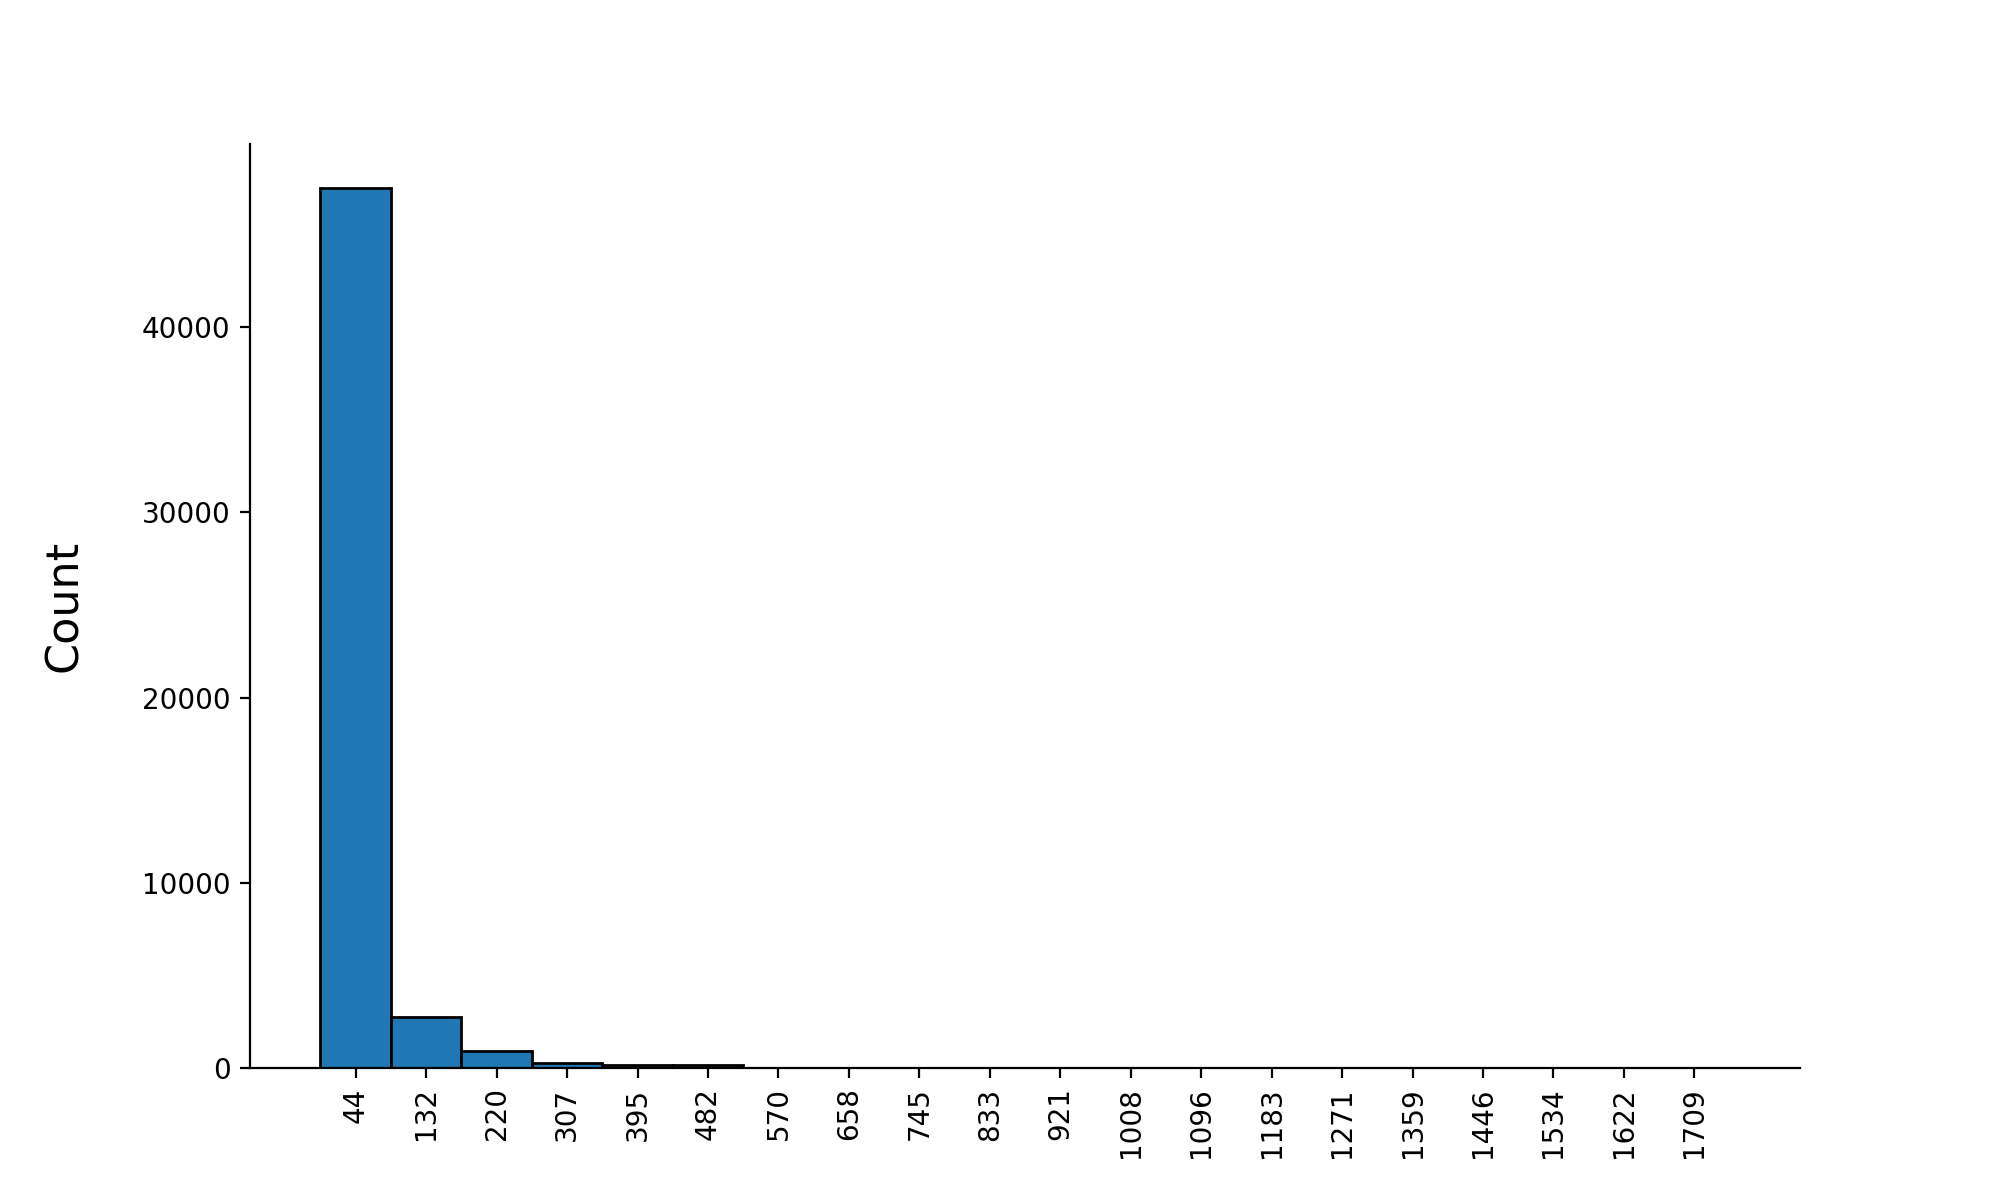

In [16]:
n_bins = 20
hist_of_numerical_feature(data_target_revenue, 'Total_revenue_at_day', n_bins)

<ipython-input-6-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


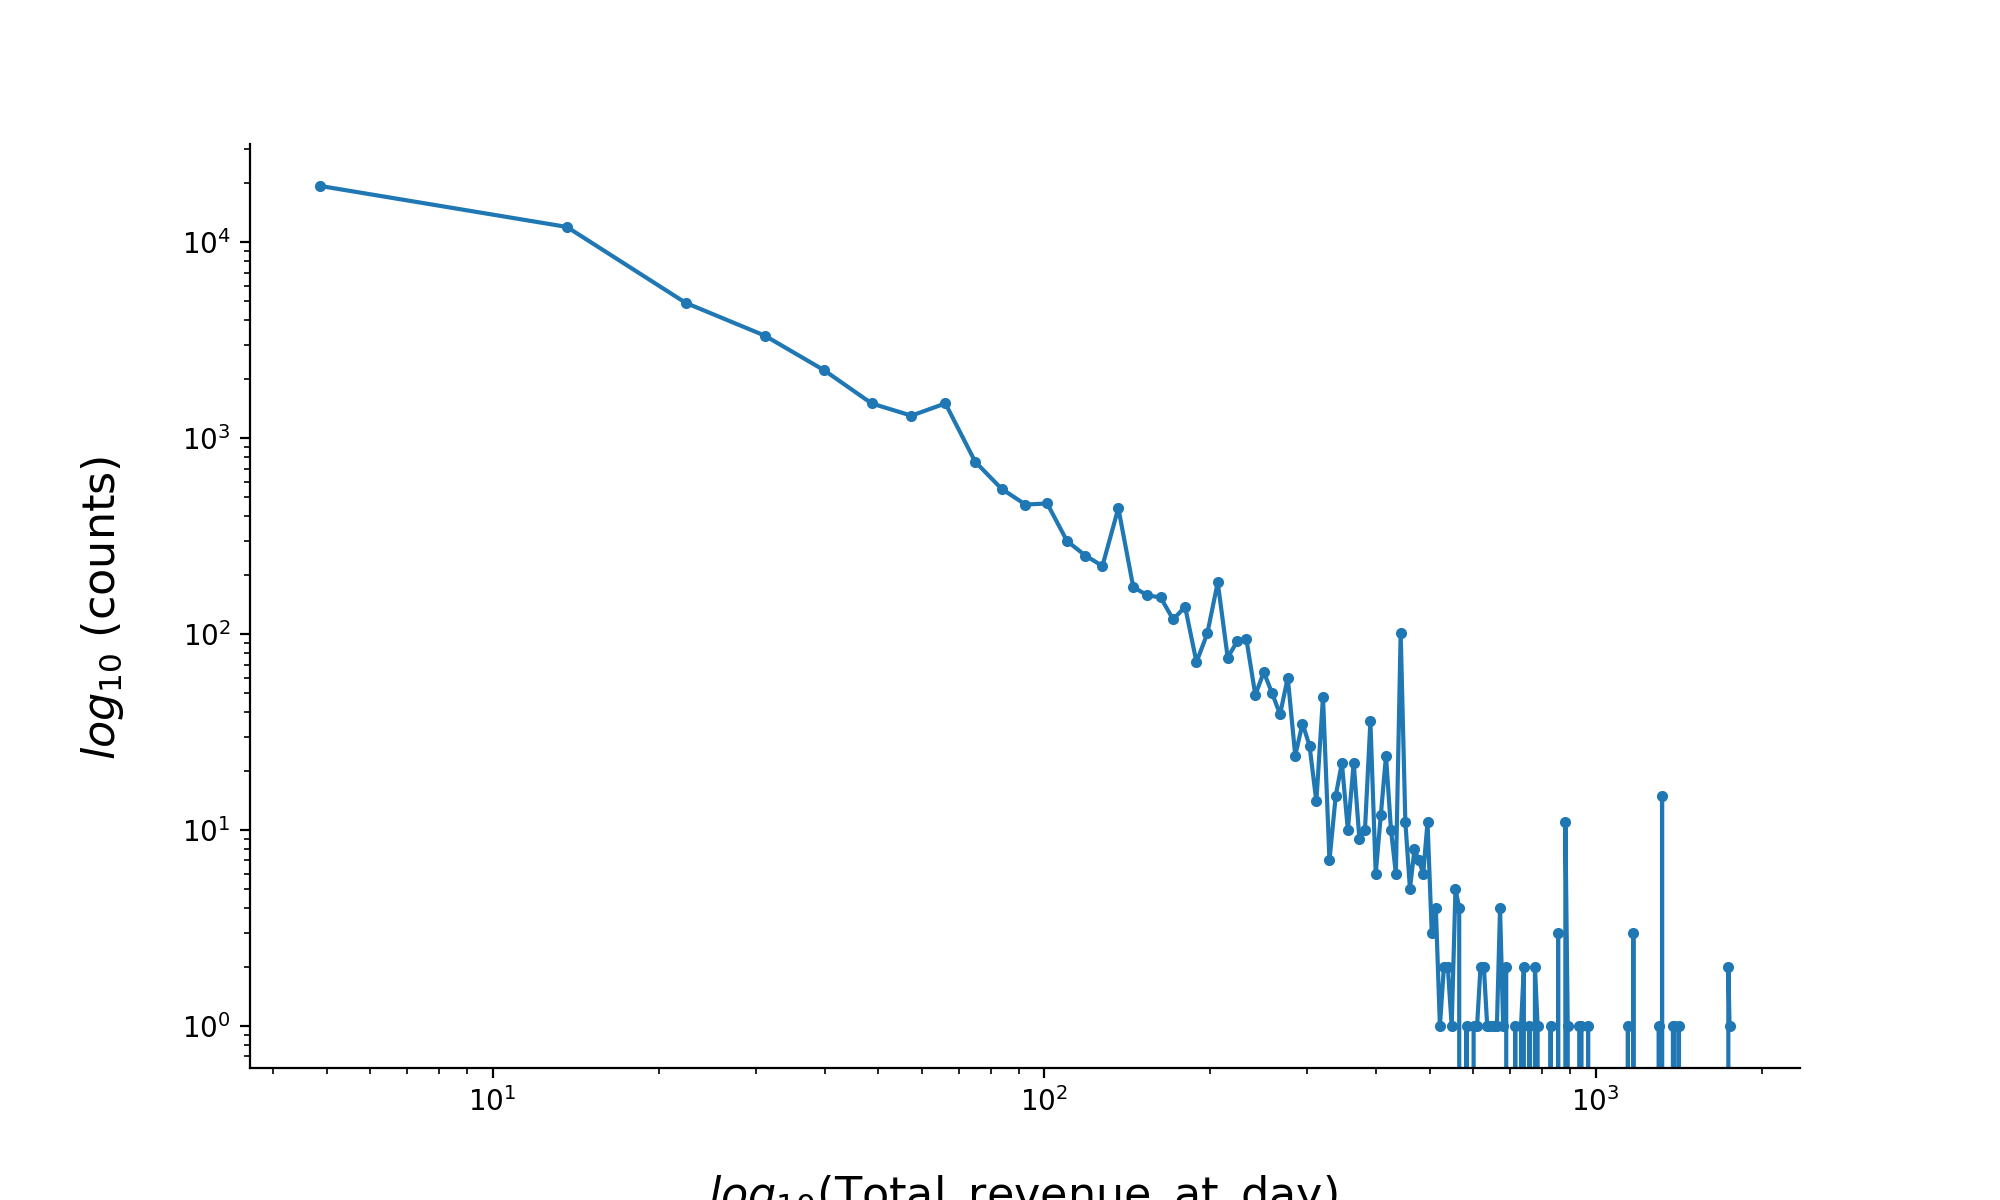

In [17]:
n_bins = 200
plot_loglog_scale(data_target_revenue, 'Total_revenue_at_day', n_bins)

The distribution of the revenue seems power-law even from a day of data. 

<IPython.core.display.Javascript object>


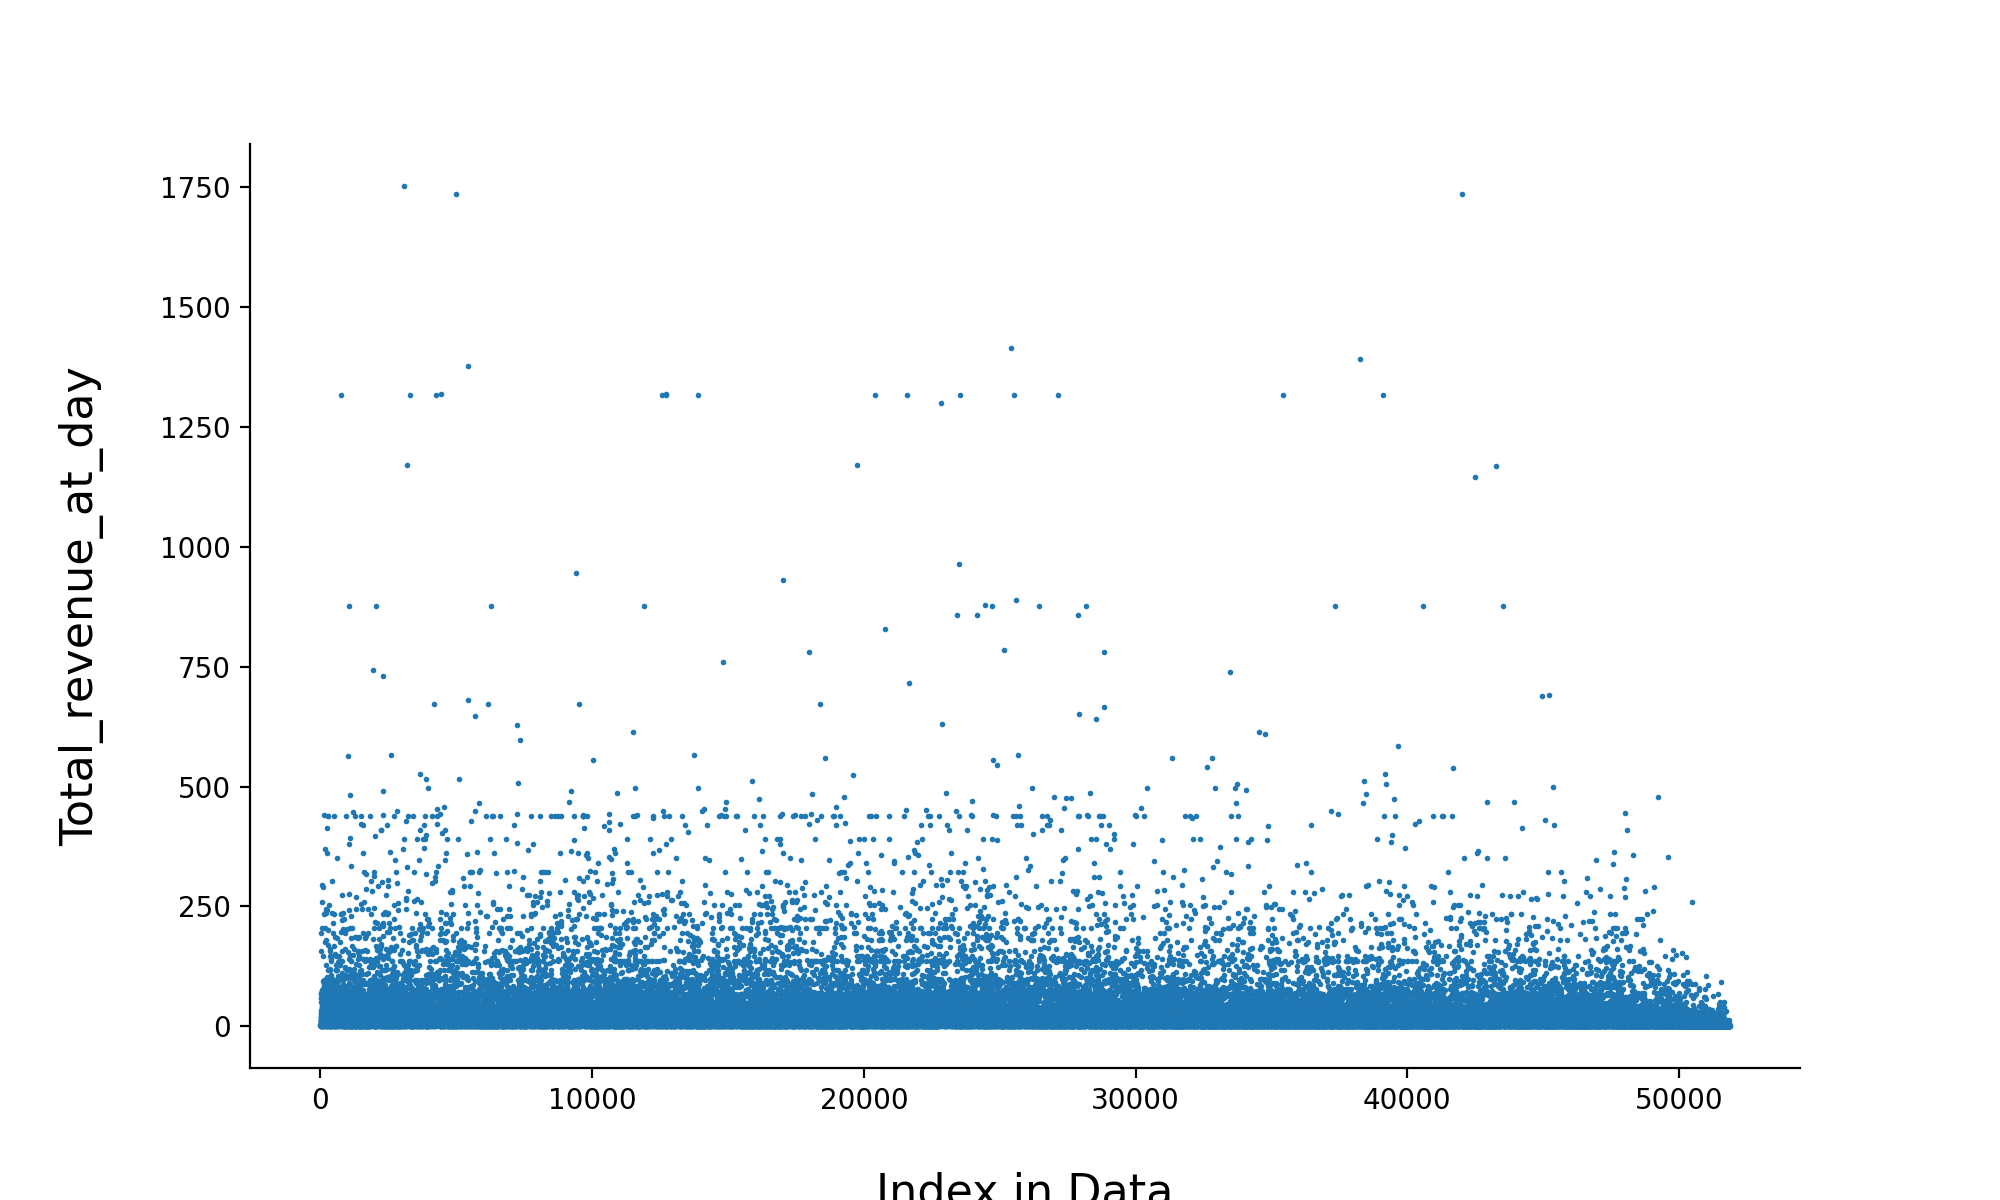


The lowest user id is: 600

and the highest user id is: 1004641327


In [18]:
marker_size = 2
plot_data_by_index(data_target_revenue, 'Total_revenue_at_day', marker_size)

print("\nThe lowest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[0]))
print("\nand the highest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[-1]))

<IPython.core.display.Javascript object>


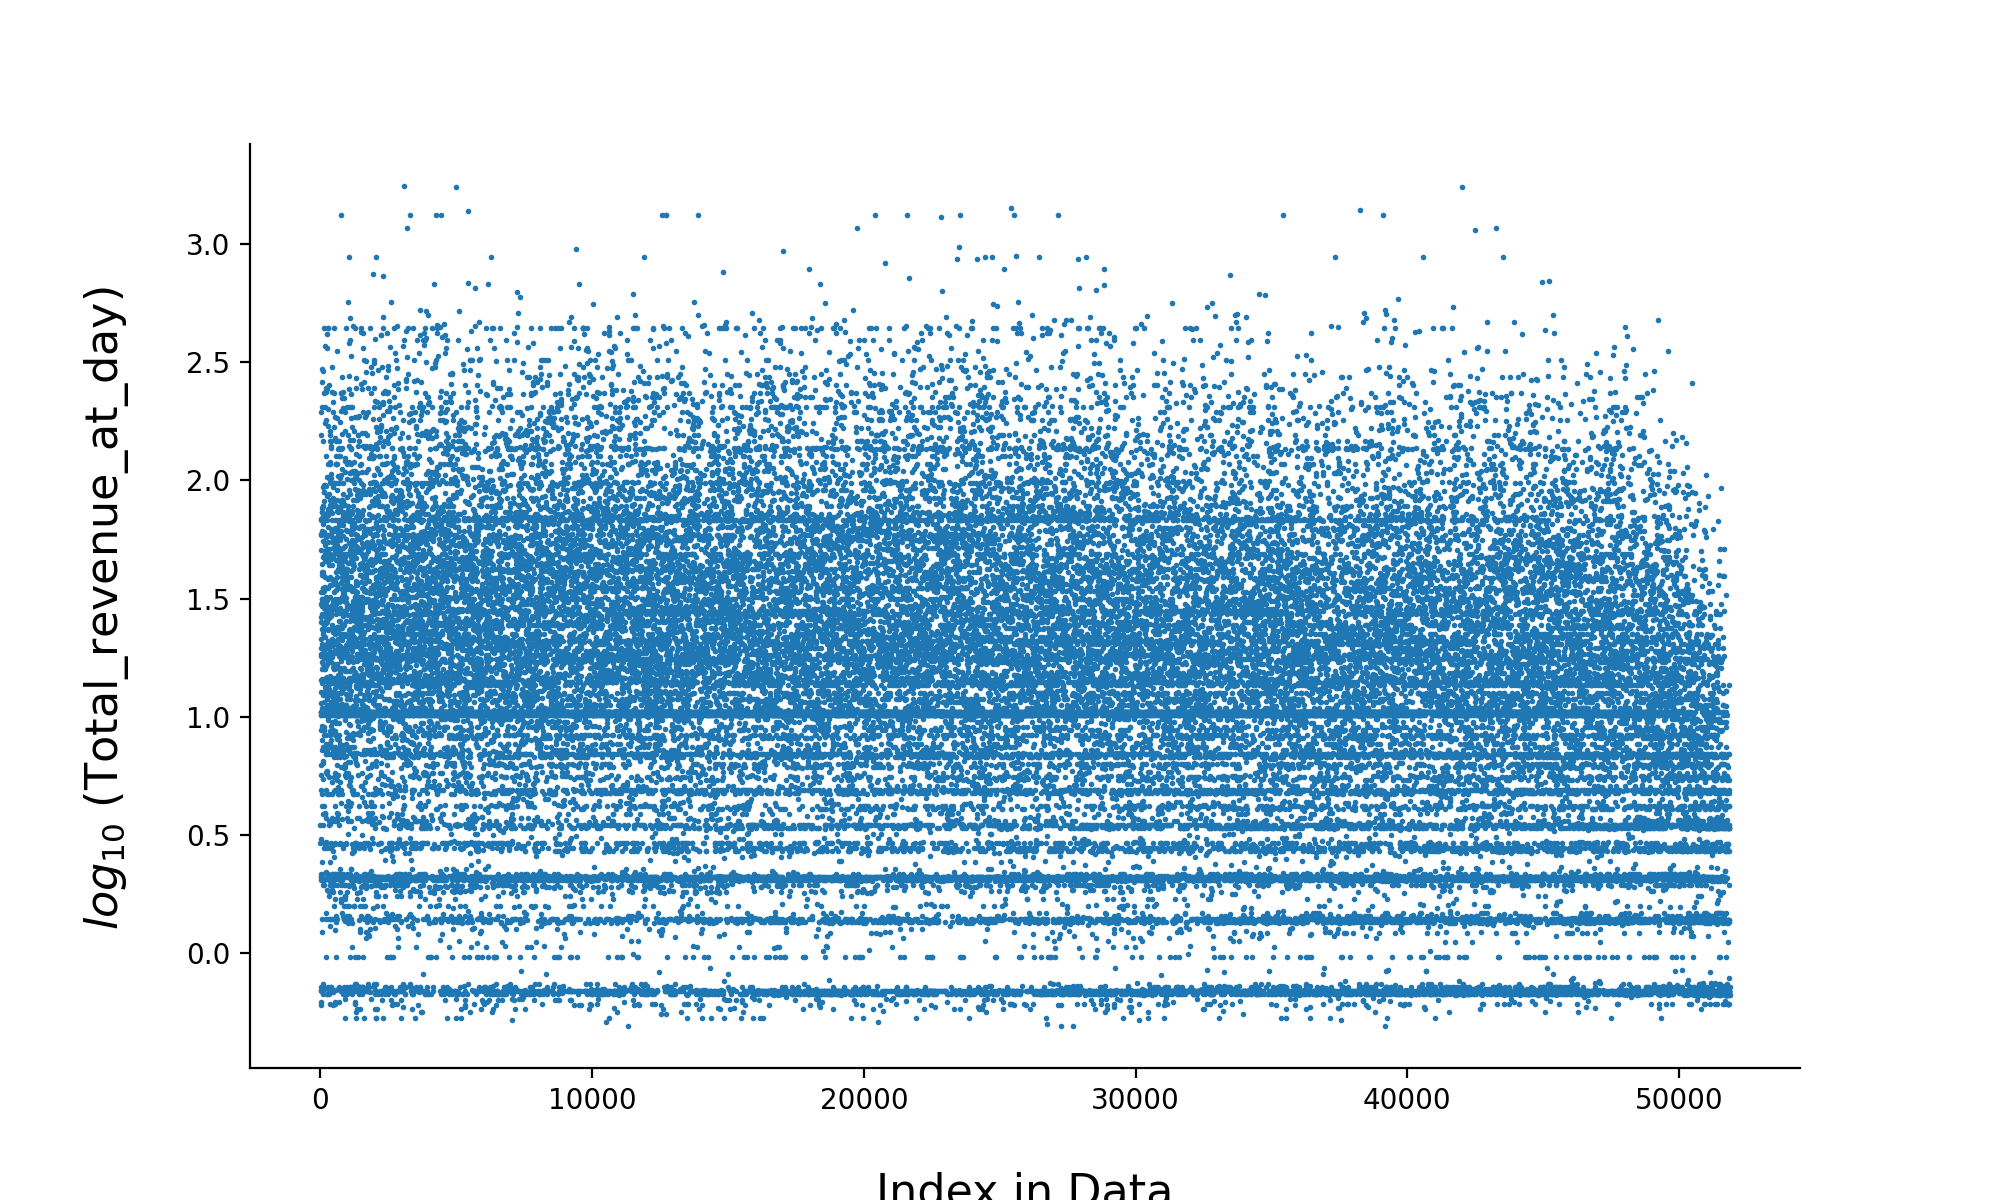

In [19]:
# And when the revenue is in log scale
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), np.log10(data_target_revenue["Total_revenue_at_day"]), '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel('$log_{10}$ (Total_revenue_at_day) ', labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

<IPython.core.display.Javascript object>


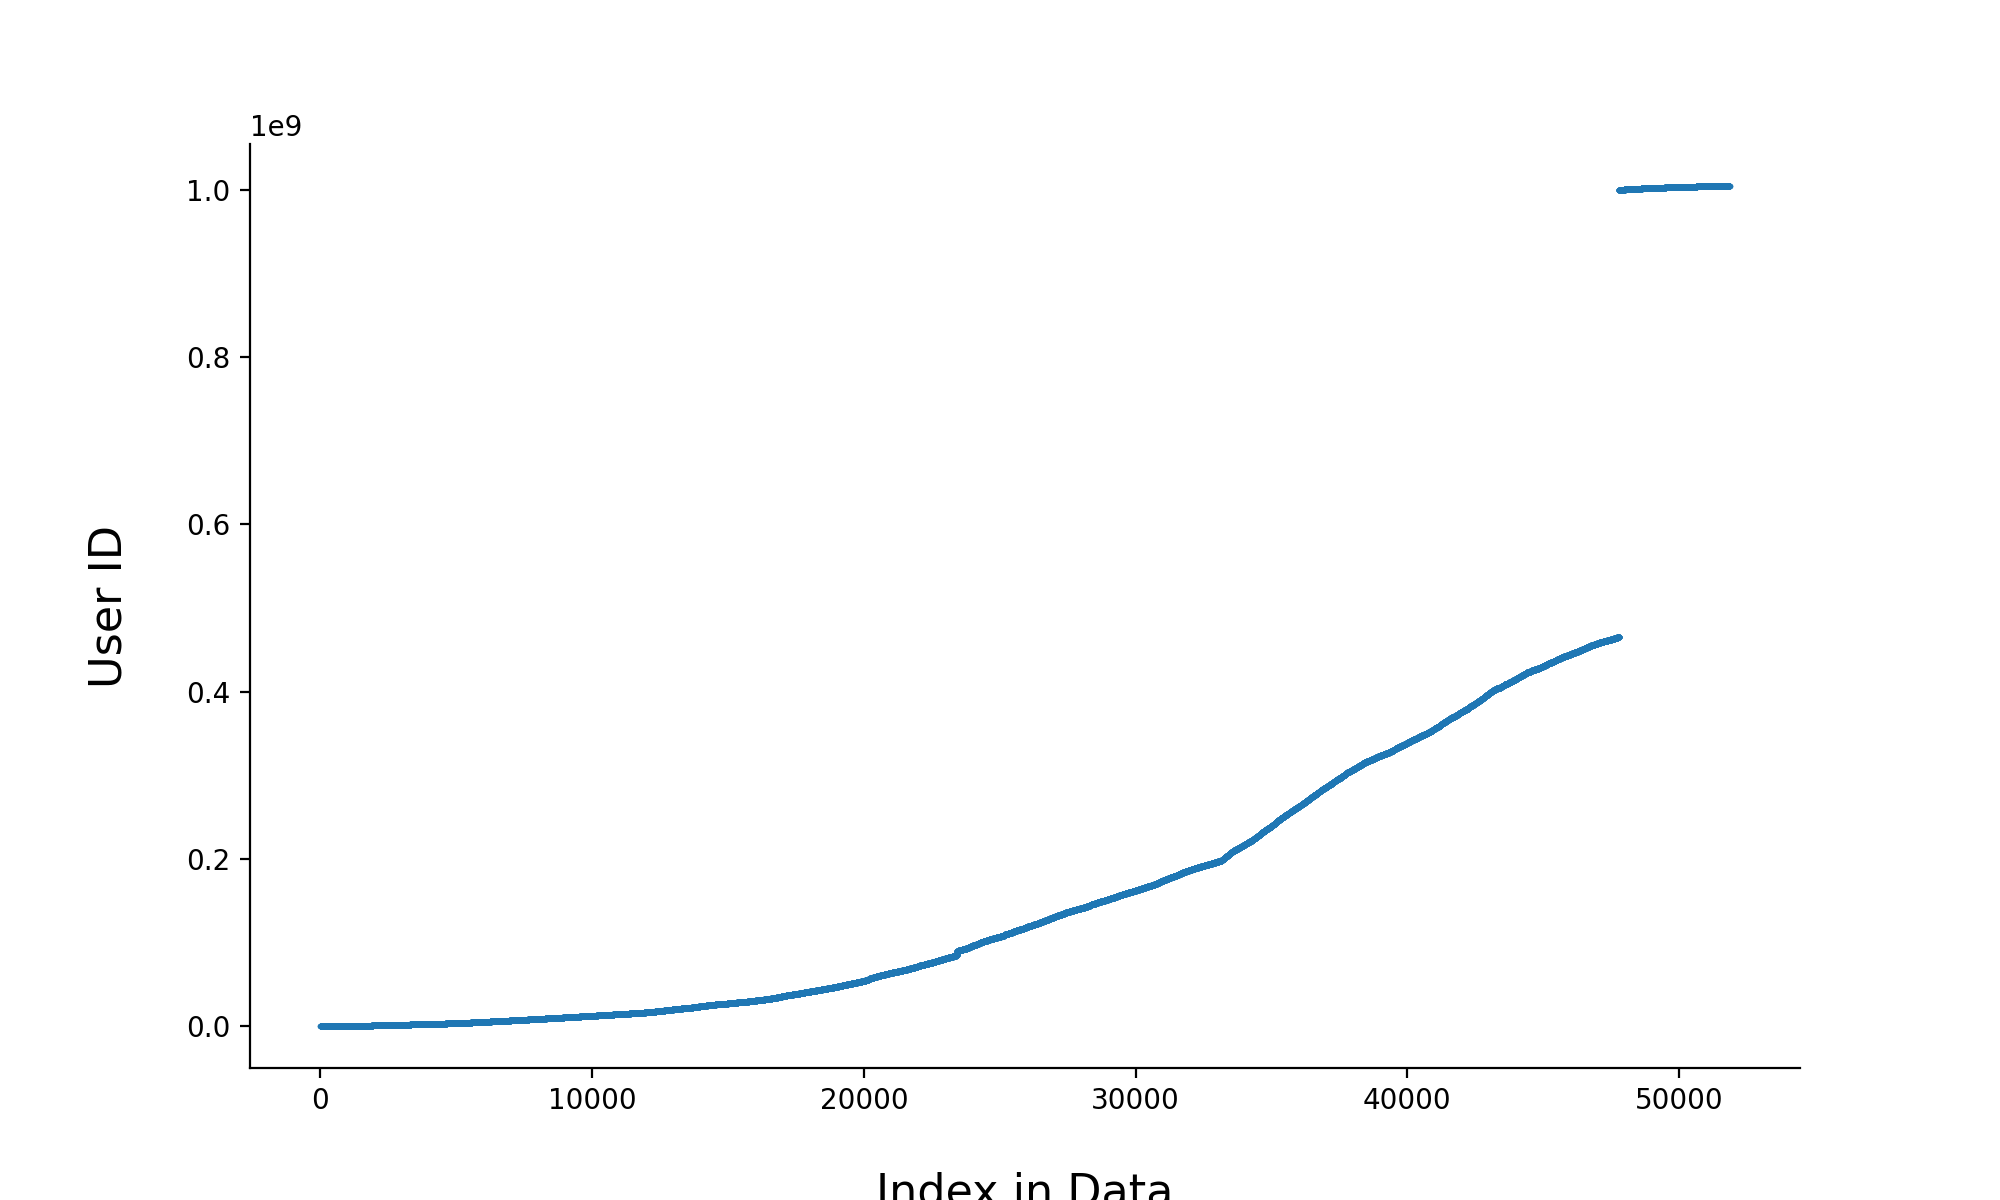

In [20]:
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), data_target_revenue["dim_user_gid"], '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel("User ID", labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

An initial analysis (part 1) suggests that the revenue depends on the seniority of the users. Here we see that although there exist a wide range of users IDs, which suggest a spread in seniority, the daily revenue seems independent of that (see figure in previous cell), at least up to the last group of users with very high numbers, that are seperated from the other users in this graph, and have lower average revenue in the above graph. 

# K - Means 

In [97]:
# data_for_clustering_for_target_revenue = data_for_clustering[['dim_user_gid', 'level', 'Last_30D_Revenue_Net', 'credits_balance_EOD']].copy()
data_for_clustering_for_target_revenue = data_for_clustering[['dim_user_gid', 'level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']].copy()

print(data_for_clustering_for_target_revenue.shape)
data_for_clustering_for_target_revenue.head(10)

(4985297, 4)


dim_user_gid  level  Last_30D_Gross_Sink  Life_Time_Login_Days
23899           261   74.0                 42.0                    72
40151           288   77.0                  0.0                    66
40152           312   97.0              16952.0                   136
40153           376  126.0                  0.0                   306
68592           381  129.0                450.0                   307
80781           388   85.0                  0.0                   109
48277           391  243.0              11580.0                  2480
3584            427  208.0              21180.0                  1164
48278           436   72.0                  0.0                   165
68593           454   64.0                  0.0                    66

In [115]:
num_of_points = 100000
X = data_for_clustering_for_target_revenue.iloc[num_of_points*10:num_of_points*11, :]
print(X.shape)
X.head()

(100000, 4)


dim_user_gid  level  Last_30D_Gross_Sink  Life_Time_Login_Days
968943     186908474  101.0                240.0                   558
960609     186908567  126.0               3626.0                   521
973126     186908591  101.0                  0.0                   114
928259     186908672  310.0              18360.0                  1304
960610     186908705  164.0              11228.0                   782

In [116]:
X.dtypes

dim_user_gid              int64
level                   float64
Last_30D_Gross_Sink     float64
Life_Time_Login_Days      int64
dtype: object

In [117]:
X[X <= 0] = 0.01
X.head()

<ipython-input-117-ca281faf9d5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X <= 0] = 0.01
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


dim_user_gid  level  Last_30D_Gross_Sink  Life_Time_Login_Days
968943     186908474  101.0               240.00                   558
960609     186908567  126.0              3626.00                   521
973126     186908591  101.0                 0.01                   114
928259     186908672  310.0             18360.00                  1304
960610     186908705  164.0             11228.00                   782

In [118]:
X['level'] = np.log10(X['level'])
X['Last_30D_Gross_Sink'] = np.log10(X['Last_30D_Gross_Sink'])
X['Life_Time_Login_Days'] = np.log10(X['Life_Time_Login_Days'])

<ipython-input-118-853f393f6b40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['level'] = np.log10(X['level'])
<ipython-input-118-853f393f6b40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Last_30D_Gross_Sink'] = np.log10(X['Last_30D_Gross_Sink'])
<ipython-input-118-853f393f6b40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [119]:
X.head(10)

dim_user_gid     level  Last_30D_Gross_Sink  Life_Time_Login_Days
968943     186908474  2.004321             2.380211              2.746634
960609     186908567  2.100371             3.559428              2.716838
973126     186908591  2.004321            -2.000000              2.056905
928259     186908672  2.491362             4.263873              3.115278
960610     186908705  2.214844             4.050302              2.893207
960611     186908720  1.819544            -2.000000              1.518514
965028     186908861  1.778151            -2.000000              1.342423
908172     186908927  1.954243            -2.000000              2.532754
912369     186908966  1.897627            -2.000000              2.378398
940611     186909089  2.356026             4.375846              3.200577

In [120]:
# Applying the method
check_nan = X['Last_30D_Gross_Sink'].isnull().values.any()
 
# printing the result
print(check_nan)

False


In [150]:
kmeans_kwargs = {
                "init": "random",
                "n_init": 10,
                "random_state": 42,
                }

In [167]:
sse = []
silhouette_coefficients = []

# A flag for whether to calculate the silhouette, as it takes quite some time for large data set.
calc_silhouette = True

for k in range(1, 5):
    print(k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']])
    sse.append(kmeans.inertia_)
    
    if k > 1 and calc_silhouette:
        score = silhouette_score(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']], kmeans.labels_)
        silhouette_coefficients.append(score)

1
2
3
4


<IPython.core.display.Javascript object>


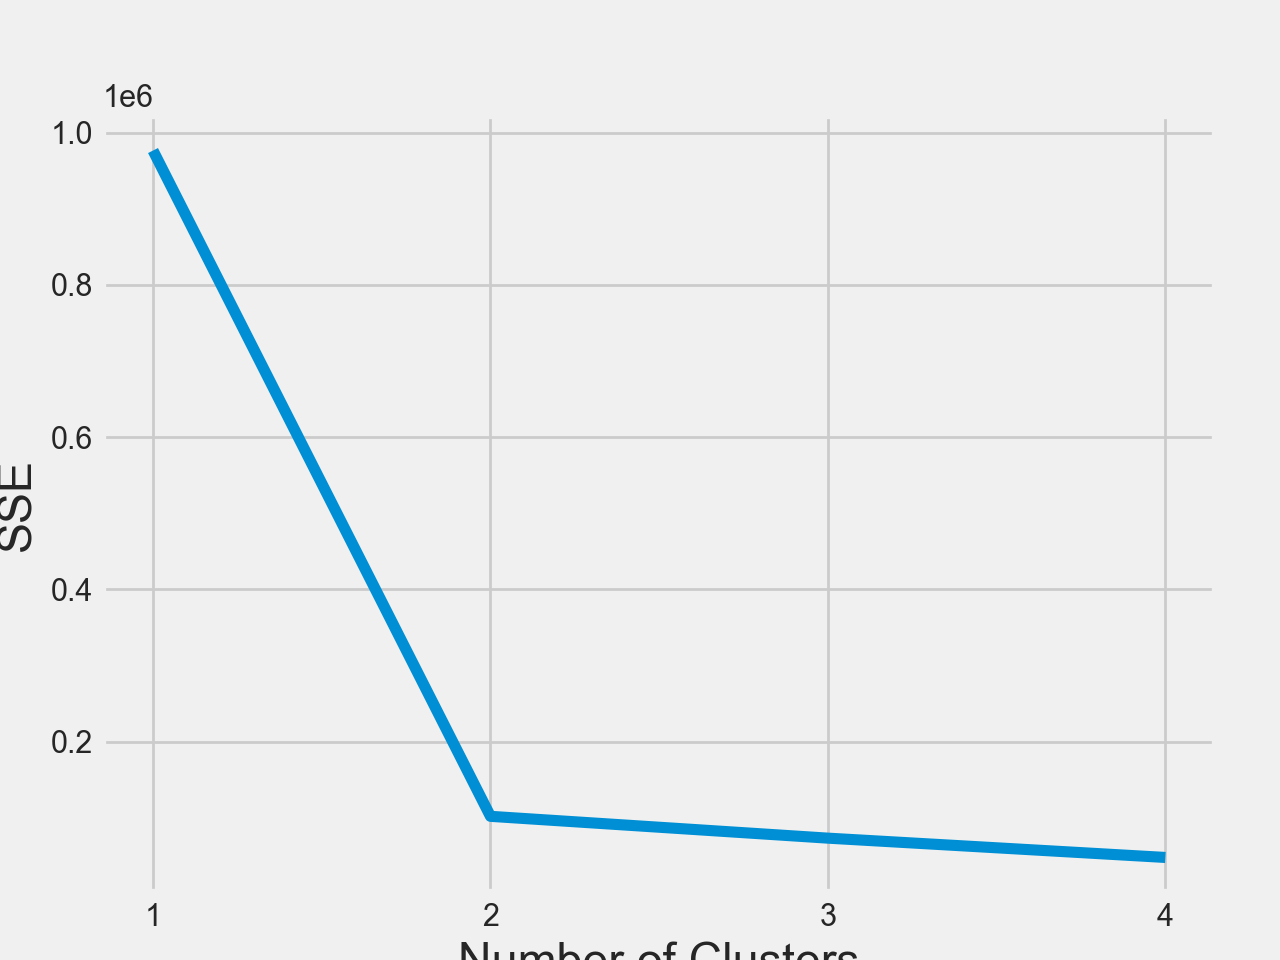

In [170]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 5), sse)
plt.xticks(range(1, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [171]:
kl = KneeLocator(range(1, 5), sse, curve="convex", direction="decreasing")
print("The preferred number of clusters is: {}.".format(kl.elbow))

The preferred number of clusters is: 2.


<IPython.core.display.Javascript object>


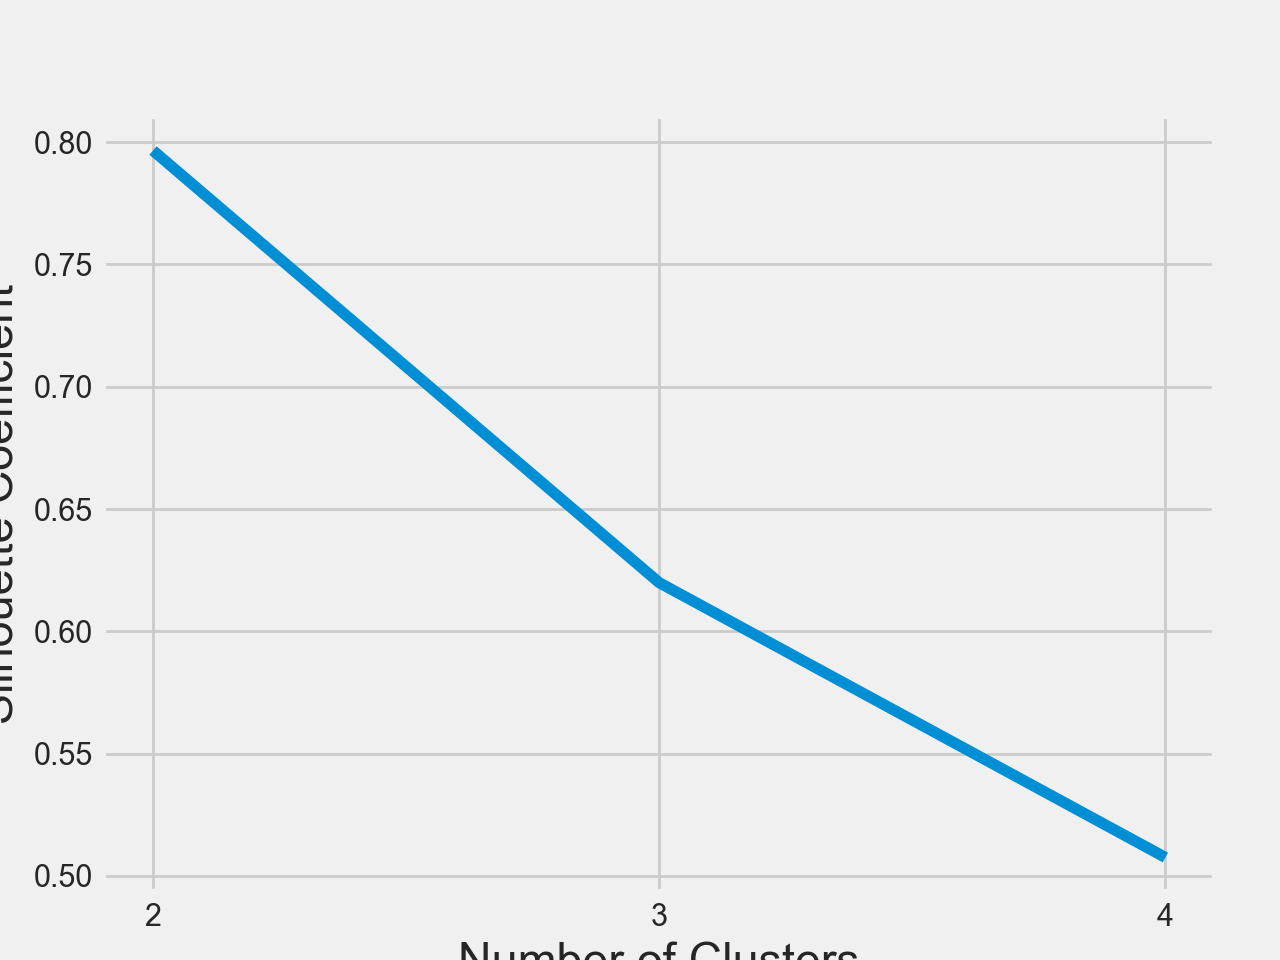

In [172]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [155]:
# Create cluster feature

num_of_clusters = 2

start_time = time.time()
kmeans = KMeans(n_clusters=num_of_clusters, random_state = 42)
X["Cluster"] = kmeans.fit_predict(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']])
X["Cluster"] = X["Cluster"].astype("category")
end_time = time.time()

print("The Kmeans calculation for 3 dimensions and {} rows was:\n{}sec".format(X.shape[0], end_time - start_time))

X.head()

The Kmeans calculation for 3 dimensions and 100000 rows was:
0.13254117965698242sec


<ipython-input-155-56da1fb8435b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster"] = kmeans.fit_predict(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']])
<ipython-input-155-56da1fb8435b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster"] = X["Cluster"].astype("category")


dim_user_gid     level  Last_30D_Gross_Sink  Life_Time_Login_Days  \
968943     186908474  2.004321             2.380211              2.746634   
960609     186908567  2.100371             3.559428              2.716838   
973126     186908591  2.004321            -2.000000              2.056905   
928259     186908672  2.491362             4.263873              3.115278   
960610     186908705  2.214844             4.050302              2.893207   

       Cluster  
968943       0  
960609       0  
973126       1  
928259       0  
960610       0

<IPython.core.display.Javascript object>


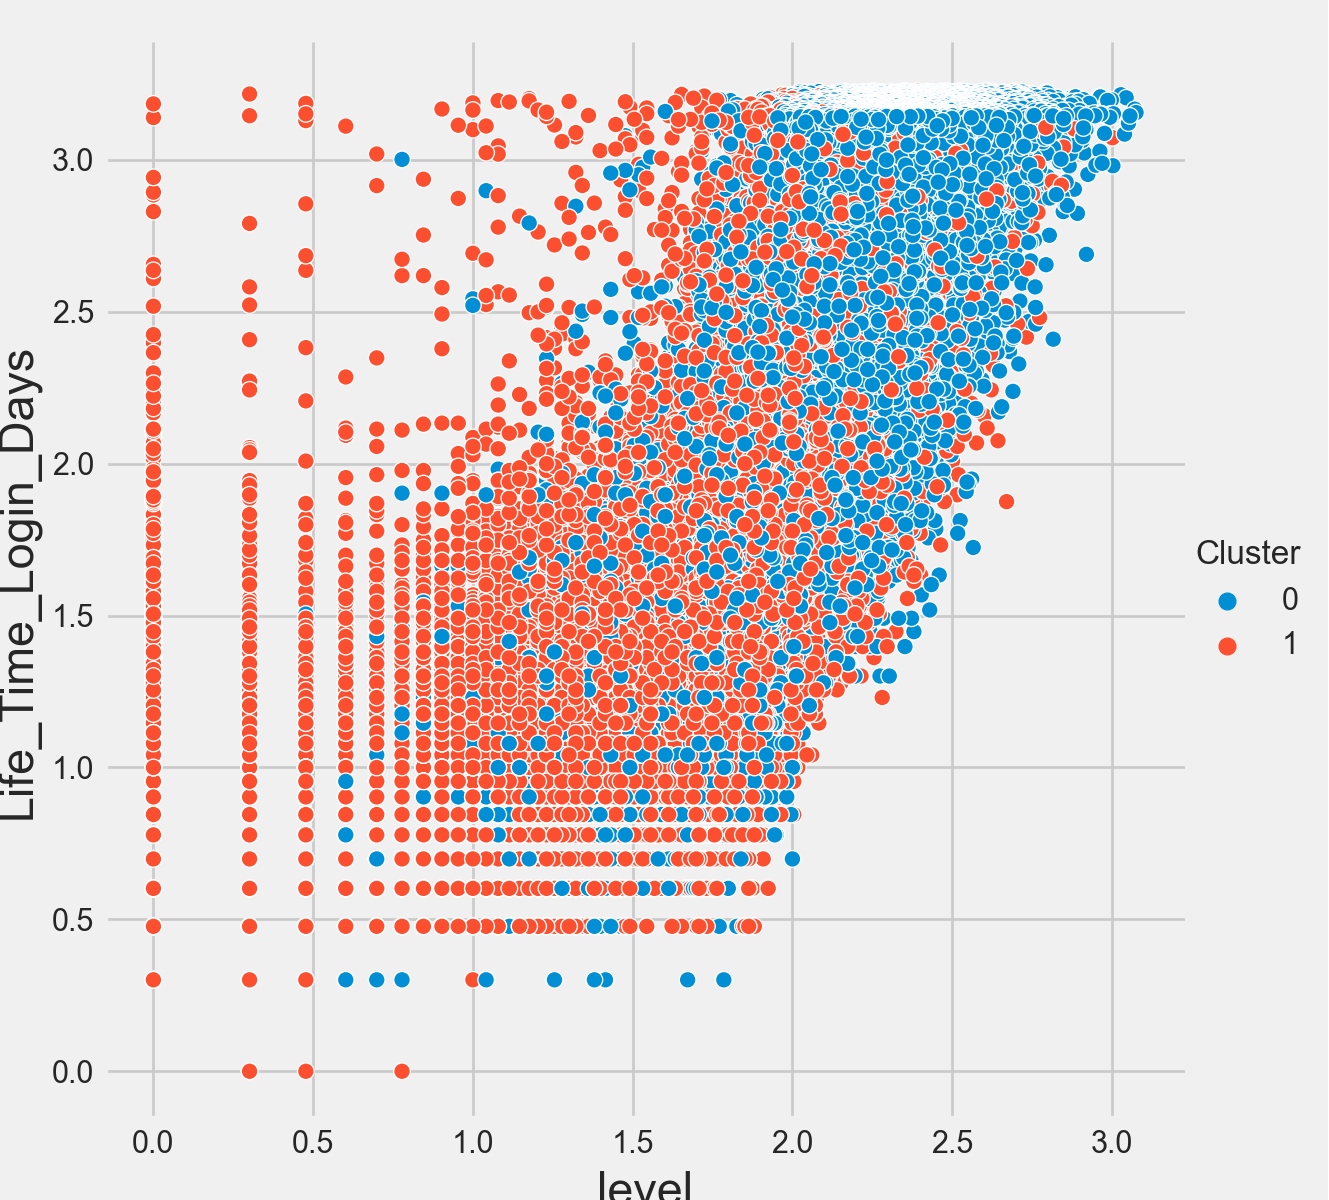

In [156]:
sb.relplot(
    x="level", y="Life_Time_Login_Days", hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


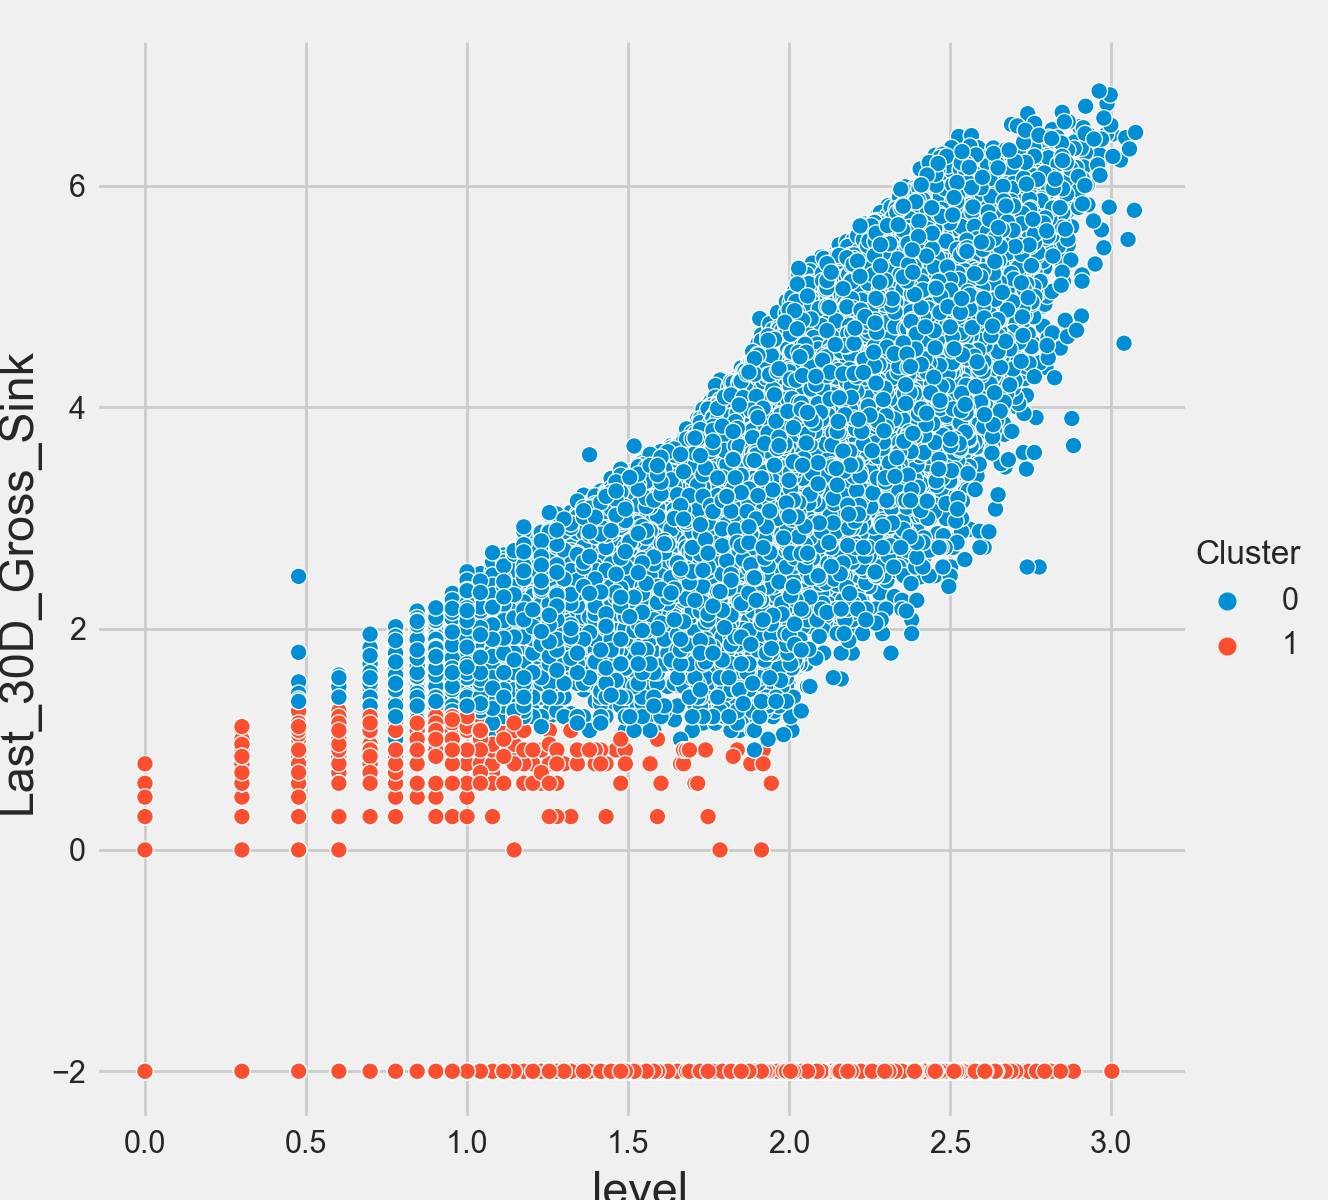

In [157]:
sb.relplot(
    x="level", y="Last_30D_Gross_Sink", hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


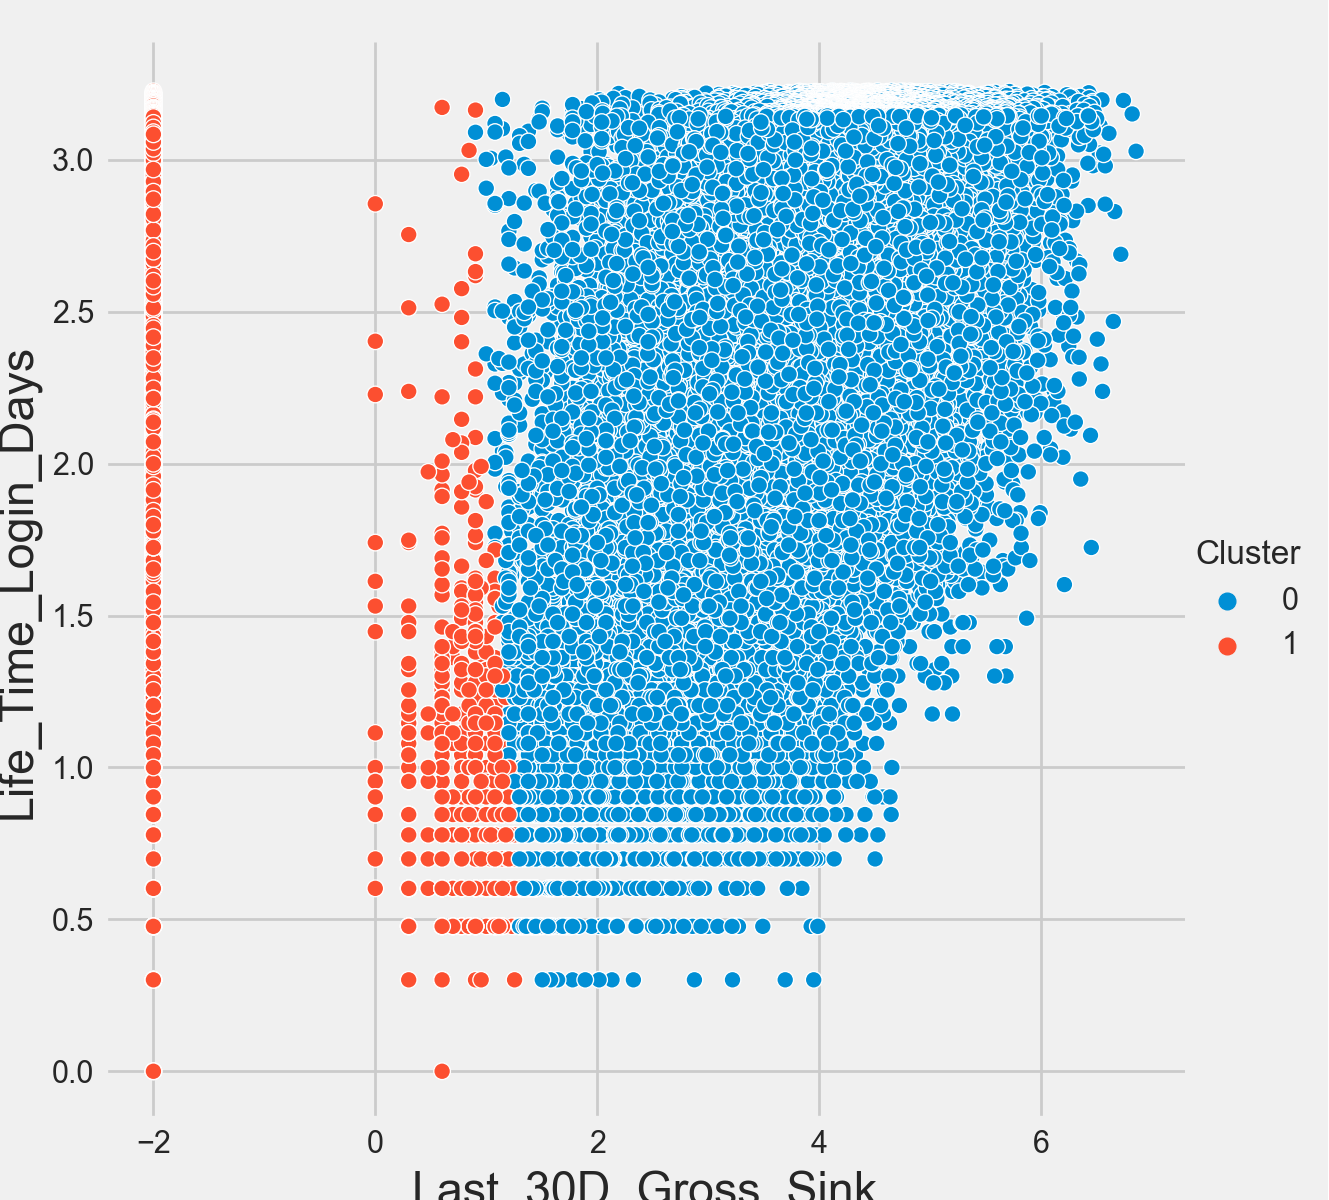

In [158]:
sb.relplot(
    x="Last_30D_Gross_Sink", y="Life_Time_Login_Days", hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


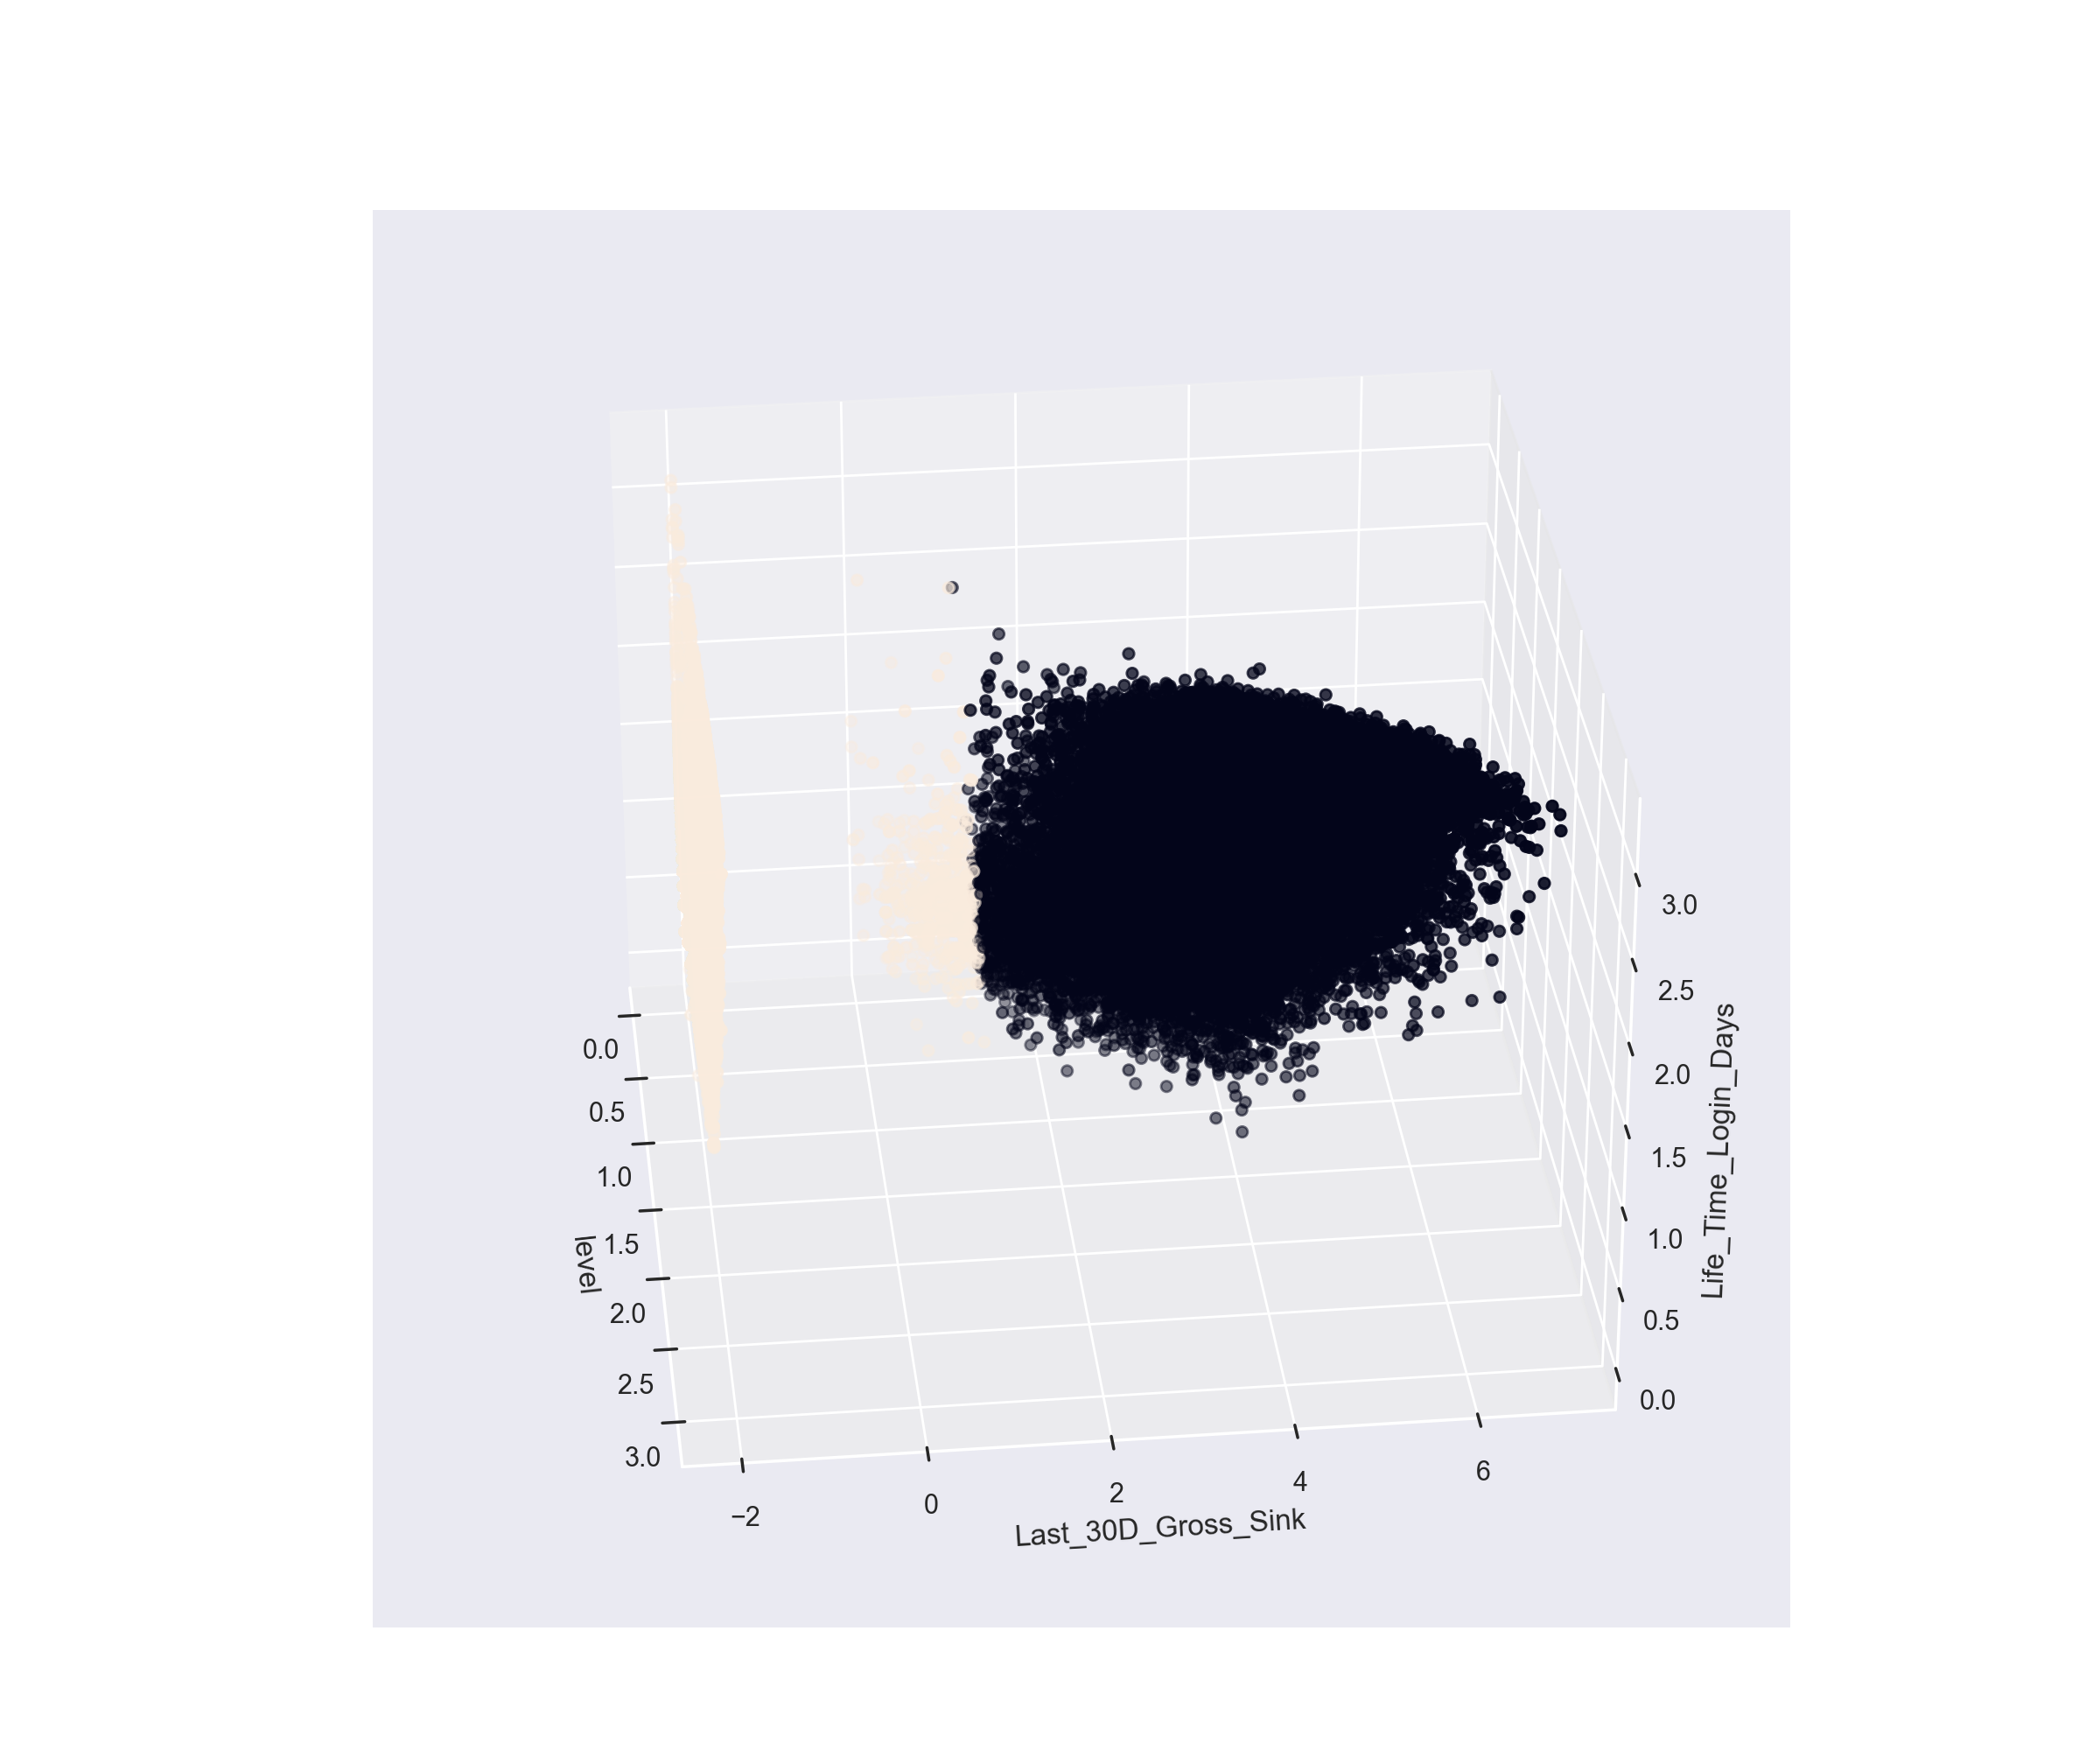

In [159]:
sb.set(style = "darkgrid")

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection = '3d')

x = X['level']
y = X['Last_30D_Gross_Sink']
z = X['Life_Time_Login_Days']

ax.set_xlabel("level")
ax.set_ylabel("Last_30D_Gross_Sink")
ax.set_zlabel("Life_Time_Login_Days")

ax.scatter(x, y, z, c = X['Cluster'])

plt.show()

In [160]:
X_merged_with_target = find_users_in_both_data_and_target_frames(X, data_target_revenue)


A short summary:
The target frame was merged with the historical data frame, and it includes *only* users that appears in both.
There are 118 different rows, and 7 different columns.
There are 0 *nan* values at the dim_user_gid column.
There are 118 unique values at the dim_user_gid column.

Keeping only the last entry of each duplicate.
The end data frame has 118 rows.
It was sorted by the dim_user_gid column.



In [161]:
X_merged_with_target.head()

dim_user_gid     level  Last_30D_Gross_Sink  Life_Time_Login_Days  \
937062      187256717  2.307496             2.838849              2.795185   
940762      187593989  2.193125            -2.000000              2.952308   
960834      187871933  2.004321             3.755417              2.853090   
928498      187893986  2.004321            -2.000000              3.147367   
1892430     187899353  2.107210             3.699838              3.214844   

        Cluster  Total_revenue_at_day  num_purchase_events_of_user  
937062        0                1.7530                            1  
940762        1                0.6733                            1  
960834        0                7.2478                            2  
928498        1                2.7631                            1  
1892430       0               34.9930                            1

<IPython.core.display.Javascript object>


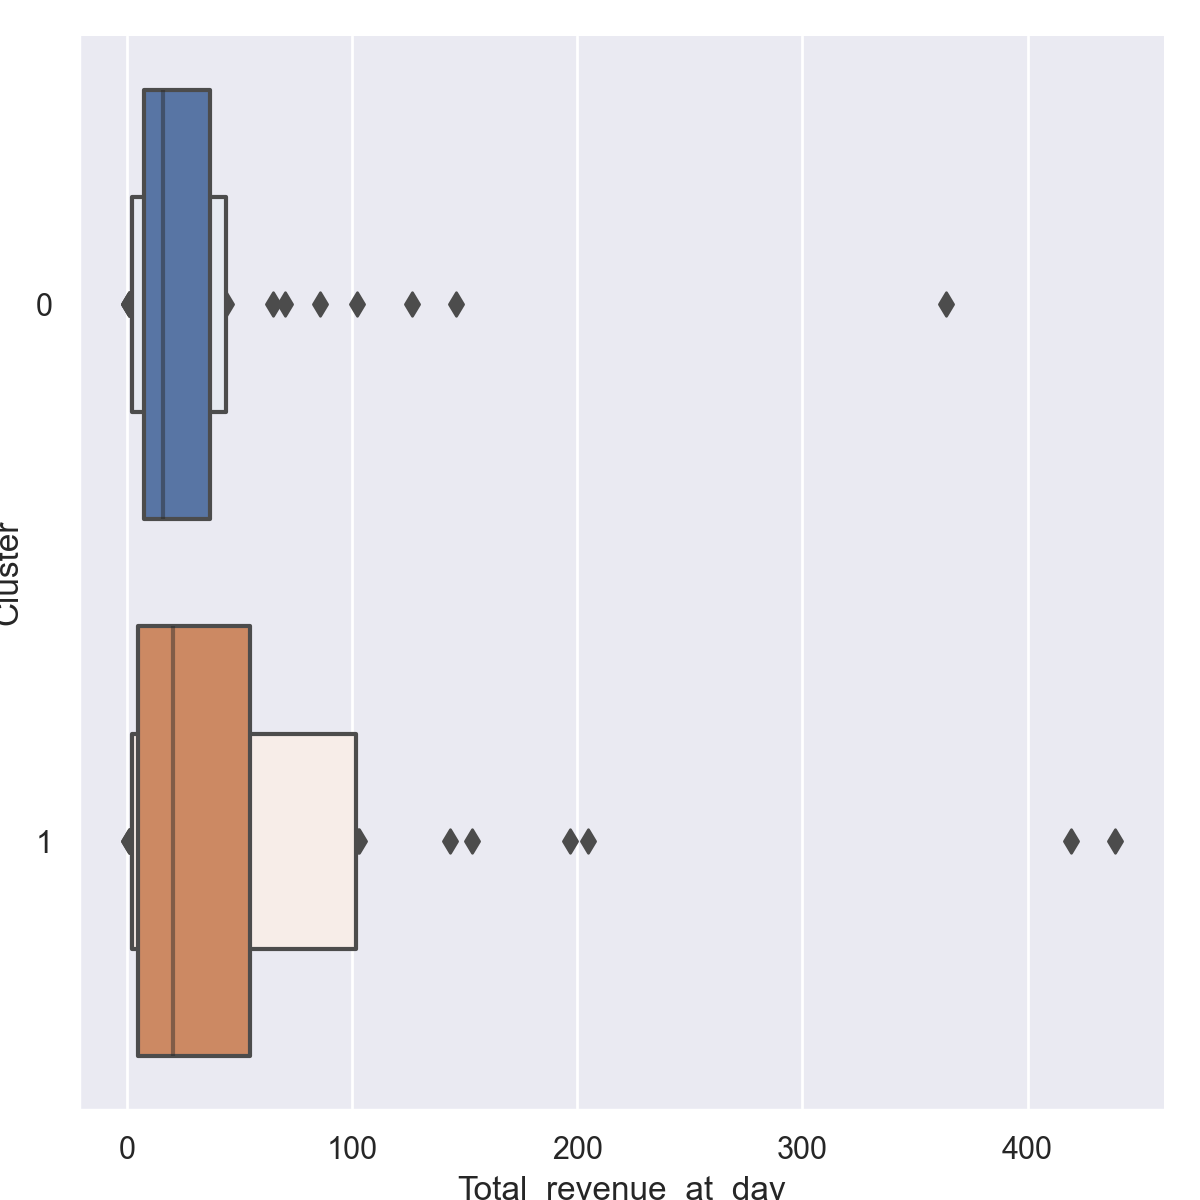

In [162]:
sb.catplot(x="Total_revenue_at_day", y="Cluster", data=X_merged_with_target, kind="boxen", height=6)
plt.show()